# Задание 2. Метрические алгоритмы классификации

Работа выполнена Алескиным Александром, 317 группа

Задания выполнены последовательно и с описанием условия (выполнялись в несколько этапов, поэтому не все метки идут последовательно).

#### 1. Загрузить датасет MNIST при помощи функции sklearn.datasets.fetch_mldata("MNIST original").

In [1]:
from sklearn.datasets import fetch_mldata # подключаем библиотеку
data = fetch_mldata("MNIST original") # загружаем данные

#### 2. Разбить датасет на обучающую выборку (первые 60 тыс. объектов) и тестовую выборку (10 тыс. послед них объектов). Ответы на тестовой выборке не следует использовать ни в каких экспериментах, кроме финального.

In [2]:
N = 6 * (10 ** 4) # size of train data
from sklearn.utils import shuffle 
data_shuffle, ans_shuffle = shuffle(data['data'], data['target']) # перемешиваем данные
X_train , y_train = data_shuffle[:N, :], ans_shuffle[:N]
X_test,   y_test  = data_shuffle[N:, :], ans_shuffle[N:]

Так как будем решать задачу классификации, то тип данных float в ответах на выборках излишен (и даже неудобен):

In [4]:
y_train = np.int32(y_train)
y_test = np.int32(y_test)

Посмотрим, равномерно ли по классам разбилась выборка:

In [3]:
import numpy as np
print (np.mean(y_train), np.std(y_train))
print (np.mean(y_test), np.std(y_test))

4.44645 2.88834423113
4.4883 2.90087281865


Неплохое разбиение.

#### 3. Визуализировать по 5 случайных объектов из каждого из 10 классов. Воспользуйтесь методами np.reshape, pyplot.subplot, и pyplot.imshow с параметром cmap="Greys". Также можно убрать оси координат при помощи команды pyplot.axis("off").

In [23]:
# подключим соответсвующие библиотеки
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

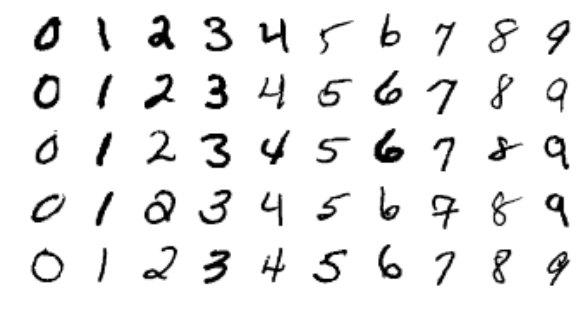

In [90]:
classes = 10
class_objects = 5
plt.figure(figsize = (10,5))
for i in range(10):
    arguments = np.argwhere(np.isclose(y_train, float(i))) # array of index of objects which are in class i
    for j in range(class_objects):
        image = X_train[arguments[j]]
        image = image.reshape((28,28)) # делаем изображение квадратным 
        plt.subplot(class_objects, classes, j*classes + i + 1) # указываем номер изображения
        plt.imshow(image, cmap = "Greys")
        plt.axis("off")
        
    
    

#### 4. Исследовать, каким точным алгоритмом поиска ближайших соседей следует пользоваться в различных ситуациях. Будем искать 5 ближайших соседей в обучающей выборке для тестовой выборки (при этом ответы на тестовой выборке не используются!). Метрика евклидова. Число признаков: 10, 20, 100. Подмножество признаков выбирается один раз, случайно.

Мой алгоритм подсчета евклидова расстояния из первого задания (немного изменен в целях экономии времени:
отложенное взятие квадрата, так как знак сравнения одинаковый для квадратов чисел и самих чисел):

In [7]:
def var_vec(X, Y):
    """
    vectorized variant
    X,Y - objects variety of type array
    return array with eclidean dist in square between Xi and Yj objects in (i,j) element. 
    
    """
    
    XX = np.repeat(X, Y.shape[0], axis = 0)
    YY = np.tile(Y, (X.shape[0], 1))
    Z = XX-YY
    Z = np.sum(Z * Z, axis =1)
    return np.reshape(Z, (X.shape[0], Y.shape[0]))     
    

Ниже приведен код эксперимента. По скольку все алгоритмы точные, то будем искать наилучший алгоритм по времени выполнения. Так как размер тестируемой выборки влияет на все алгоритмы одинаково, то для выяснения скоростных характеристик достаточно небольших объемов тестируемых выборки. Стоит отметить, что для моего алгоритма и алгоритма brute необходимо большее количество памяти, чем для алгоритмов kd_tree и ball_tree. Поэтому разбиваем тестовую выборку для них на блоки.

In [17]:
#  подключаем функции
import time # для использования функции time.time()
from sklearn.neighbors import NearestNeighbors 

# необходимые переменные
n_neighbors = 5
n_features = np.array([10, 20, 100])
features_index = np.arange(X_train.shape[1]) 
time_set = np.zeros((4, 3))
test_size = 5000

br = NearestNeighbors(algorithm = 'brute')
kd = NearestNeighbors(algorithm = 'kd_tree')
bl = NearestNeighbors(algorithm = 'ball_tree')
func = [kd, bl] # Для удобного счета

for features in range(n_features.size): 
    np.random.shuffle(features_index)
    numbers_features = features_index[:n_features[features]] # выбираем произвольные признаки объектов
    train_features = X_train[:, numbers_features] # создаем выборку только с нужными признаками
    train_data = train_features[:-test_size]
    test_data = train_features[-test_size:]
    # так как память ограничена, разобъем тестовую выборку на подматрицы
    blocks = test_data.shape[0] // 100 #+ 1
    test_block = [i for i in range(test_data.shape[0] + 1) if i % 100 == 0] #+ [test_data.shape[0]]
    # настроим обучающую выборку для brute
    time_set[1, features] -= time.time()
    br.fit(train_data)
    time_set[1, features] += time.time()
    # по-блочно найдем ближайщих соседей
    for i in range(blocks):
        # для моей функции подсчета расстояния
        time_set[0, features] -= time.time() # засекаем время
        distances = var_vec(test_data[test_block[i]: test_block[i + 1]], train_data) #вычисляем расстояния между объектами
        neighbors = np.argsort(distances, axis = 1)[:, :n_neighbors] # выбор ближайщих соседей
        # как видно корень не нужен в данной задаче, не будем его и использовать
        time_set[0, features] += time.time()
        
        #для brute
        time_set[1, features] -= time.time()
        neighbors = br.kneighbors(test_data[test_block[i]: test_block[i + 1]], return_distance = False)
        time_set[1, features] += time.time()

    # для kd_tree и ball_tree
    for j in range(len(func)):
        f = func[j]
        time_set[j + 2, features] -= time.time()
        f.fit(train_data)
        neighbors = f.kneighbors(test_data, return_distance = False)
        time_set[j + 2, features] += time.time()        

Результаты времени работы алгоритмов: 

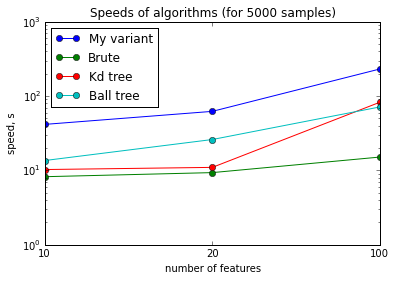

In [27]:
plt.plot(range(len(n_features)), time_set[0,:], '-o')
plt.plot(range(len(n_features)), time_set[1,:], '-o')
plt.plot(range(len(n_features)), time_set[2,:], '-o')
plt.plot(range(len(n_features)), time_set[3,:], '-o')
plt.title('Speeds of algorithms (for 5000 samples)')
plt.legend(['My variant', 'Brute', 'Kd tree', 'Ball tree'], loc='upper left')

plt.xticks(range(len(n_features)), n_features)
plt.ylabel('speed, s')
plt.xlabel('number of features')
plt.yscale('log')

Несмотря на то, что априорные оценки времени работы алгоритмов для $ N $ - объектов и $ D $ - размерности:

* Brute force --- $ O[D N] $ 
* KD tree ---   $ O[D\log(N)] $ (на небольшого размерности пространства и $ O[D N] $ для большого)
* Ball tree --- $ O[D\log(N)] $

Быстрее всех работает Brute force. Причем, это хорошо заметно на большом количестве (100) признаков. Это можно объяснить небольшим количество объектов в выборке. Так же из графика видно, что на большом количестве элементов KD tree уступил по скорости Ball tree, тем самым подтверждая верность оценок работы алгоритмов.

Данные о скорости работы алгоритмов взяты с официального сайта [scikit-learn]('http://scikit-learn.org/stable/modules/neighbors.html#choice-of-nearest-neighbors-algorithm')

#### 5. Реализовать генерацию индексов обучающей и валидационной выборки для кросс-валидации с n фолдами. Не разрешается использовать модуль sklearn.cross_validation.

In [13]:
class My_kfold:
    """
    make cross_validation with n_folds folds.
    n -- size of data,
    n_folds -- amount of folds
    
    in iterating return train and test indexes
    """
    def __init__(self, n, n_folds):
        if (type(n) != int or type(n_folds) != int or n < 1 or n_folds < 1):
            raise ValueError
        self.indexes = np.arange(n)
        self.size = n 
        self.folds = n_folds
        self.curr_it = 0
        self.stopped = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.curr_it == self.folds:
            self.curr_it = 0
            self.stopped = 0
            raise StopIteration
        else:
            start = self.stopped
            stop = start + self.size // self.folds
            if (self.curr_it < self.size % self.folds):
                stop += 1
            self.curr_it += 1
            self.stopped = stop
        return np.concatenate((self.indexes[:start], self.indexes[stop:])), self.indexes[start:stop]

#### 6. Пусть дана обучающая и валидационная выборка. Реализовать оценку точности метода k ближайших соседей по валидационной выборке для нескольких параметров k: $ [k_ 1 , . . . , k_n ], k_1 < k_2 < · · · < k_n  $. Сложность алгоритма для одного объекта из валидационной выборки должна иметь порядок O($k_n $ ). Нельзя использовать класс sklearn.neighbors.KNeighborsClassifier, можно пользоваться готовыми реализациями поиска ближайших соседей.

По результат Пункта 4 наилучший алгоритм brute. Им и воспользуемся,тем более на косинусной метрике ball_tree и kd_tree не работают:

In [177]:
from sklearn.metrics import accuracy_score

def k_neighbors_classifier(X_train, y_train, X_test, y_test, k, classes = 10, metric = 'euclidean'):
    """
    return array of accuracy for each k
    train and test should be ndarray, with same amount of features
    k is a array of int, each elements means how much neighbors should be used 
    for desicion. each element of k is bigger previous.
    metric can be euclidean or cosine
    
    """
    # проверка данных
    if X_train.shape[1] != X_test.shape[1]:
        raise ValueError
    if type(k) != np.ndarray or k.dtype != int:
        raise ValueError
    if np.where(k < 1)[0].any():
        raise ValueError("k should be positive")
    if X_train.shape[0] != y_train.shape[0] or X_test.shape[0] != y_test.shape[0]:
        raise ValueError
    
    # инициализация переменных
    accuracy = np.zeros((k.size))
    index = np.arange(X_test.shape[0])
    # обучаемая выборка не меняется
    br = NearestNeighbors(n_neighbors = k[-1], algorithm = 'brute', metric = metric).fit(X_train)
    # так как память ограничена, разобъем тестовую выборку на подматрицы
    blocks = X_test.shape[0] // 500
    test_block = [i for i in range(X_test.shape[0] + 1) if i % 500 == 0]
    if (X_test.shape[0] % 500 != 0):
        blocks += 1
        test_block += [X_test.shape[0]]
    neighbors = np.zeros((X_test.shape[0], k[-1]), dtype = int)
    for i in range(blocks):
        neighbors[test_block[i]:test_block[i + 1], :] = br.kneighbors(X_test[test_block[i]:test_block[i + 1], :],
                                                                      return_distance = False) # тестовая тоже
    
    # вычисление класса для объектов
    neighbors_classes = np.zeros((X_test.shape[0], classes))
    end = 0
    for i in range(k.size):
        start = end
        end = k[i]
        for j in range(start, end):
            neighbors_classes[index, y_train[neighbors[:,j]]] += 1
        predict = np.argmax(neighbors_classes, axis = 1)
        accuracy[i] = accuracy_score(y_test, predict)
    return accuracy
    

#### 7. Оценить по кросс-валидации с 3 фолдами точность (долю правильно предсказанных ответов) и скорость метода k ближайших соседей в зависимости от следующих факторов:
 1. k от 1 до 10 (только влияние на точность).
 2. Используется евклидова или косинусная метрика.

Пункт 1. k от 1 до 10 (только влияние на точность, но посчитаем время сразу, чтобы не пересчитывать его в следующем пункте):

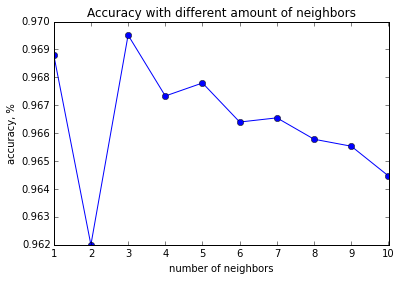

In [37]:
import time # для использования функции time.time()
from sklearn.neighbors import NearestNeighbors 

folds = 3
kf = My_kfold(X_train.shape[0], n_folds = folds)
k = np.arange(1, 11, 1)
accuracy = np.zeros((k.size))
timing = 0

for train, test in kf:
    timing -= time.time()
    accuracy += k_neighbors_classifier(X_train[train], y_train[train],
                                       X_train[test], y_train[test], k = k)
    timing += time.time()
accuracy /= folds
timing /= folds
plt.plot(k, accuracy, '-o')
plt.title('Accuracy with different amount of neighbors')
plt.ylabel('accuracy, %')
plt.xlabel('number of neighbors')

In [40]:
print("%.4f" % accuracy.max())

0.9695


Оптимальное количество соседней $ k = 3 $ (при этом точность 0.9695). Практически отсутствующая зависимость от количества соседей и высокий показатель, говорит о хорошей делимости классов. Скачок при $ k = 2 $ говорит, что у некоторых объектов классов второй ближайщий сосед из другого класса (скорее всего это классы семерок и единиц, а np.argmax() в функции выбирает первый максимум (то есть класс единиц, хотя класс семерок), взвешенный вариант должен исправить).

Пункт 2. Используется евклидова или косинусная метрика( в первой части для евклидового уже все посчитали):


In [41]:
import time # для использования функции time.time()
from sklearn.neighbors import NearestNeighbors 

folds = 3
kf = My_kfold(X_train.shape[0], n_folds = folds)
k = np.arange(1, 11, 1)
accuracy_cos = np.zeros((k.size))
timing_cos = 0
for train, test in kf:
    timing_cos -= time.time()
    accuracy_cos += k_neighbors_classifier(X_train[train], y_train[train],
                                       X_train[test], y_train[test], 
                                       k = k, metric = 'cosine')
    timing_cos += time.time()

timing_cos /= folds
accuracy_cos /= folds
accuracy_ecl = accuracy
timing_ecl = timing

Bремя работы алгоритма на евклидовой метрике 151.83 секунд (для одного фолда)
Bремя работы алгоритма на косинусной метрике 164.85 секунд (для одного фолда)


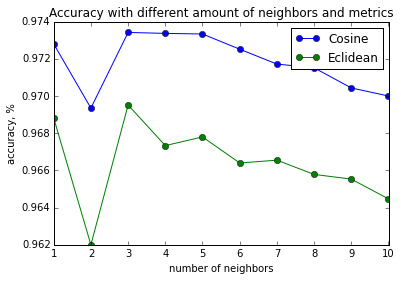

In [47]:
plt.plot(k, accuracy_cos,'-o', k, accuracy_ecl, '-o')
plt.title('Accuracy with different amount of neighbors and metrics')
plt.legend(['Cosine', 'Eclidean'], loc='upper right')
plt.ylabel('accuracy, %')
plt.xlabel('number of neighbors')

print("Bремя работы алгоритма на евклидовой метрике %.2f секунд (для одного фолда)" % timing_ecl)
print("Bремя работы алгоритма на косинусной метрике %.2f секунд (для одного фолда)" % timing_cos)

In [48]:
print("%.4f" % np.mean(accuracy_cos - accuracy_ecl))

0.0054


В среднем точность косинусной метрики на 0.005 выше евклидовой, но косинусная дольше работает. 

#### 8. Реализовать взвешенный метод k ближайших соседей, где голос объекта равен 1/(distance + ε), где ε — малое число. Сравнить с методом без весов при тех же фолдах и тех же параметрах.

Разница данной реализации от предыдущей только в том, что голос будет зависит от расстояния, поэтому с небольшими изменениями скопирована из пункта 6.

Функция:

In [16]:
from sklearn.neighbors import NearestNeighbors 
from sklearn.metrics import accuracy_score

def k_neighbors_classifier_smooth(X_train, y_train, X_test, y_test, k,
                                  metric = 'euclidean', classes = 10, return_classes = False):
    """
    return array of accuracy for each k
    train and test should be ndarray, with same amount of features
    k is a array of int, each elements means how much neighbors should be used 
    for desicion. each element of k is bigger previous.
    metric can be euclidean or cosine
    return_classes - return class for each element in test sample
    
    """
    # проверка данных
    if X_train.shape[1] != X_test.shape[1]:
        raise ValueError
    if type(k) != np.ndarray or k.dtype != int:
        raise ValueError
    if np.where(k < 1)[0].any():
        raise ValueError("k should be positive")
    if X_train.shape[0] != y_train.shape[0] or X_test.shape[0] != y_test.shape[0]:
        raise ValueError
    
    # инициализация переменных
    eps = 0.00001
    accuracy = np.zeros((k.size))
    predict = np.zeros((X_test.shape[0], k.size), dtype = int)
    index = np.arange(X_test.shape[0])
    bl = NearestNeighbors(n_neighbors = k[-1], algorithm = 'brute', metric = metric).fit(X_train)
    # обучаемая выборка не меняется (тестовая тоже)
    # так как память ограничена, разобъем тестовую выборку на подматрицы по 500 элементов
    blocks = X_test.shape[0] // 500
    test_block = [i for i in range(X_test.shape[0] + 1) if i % 500 == 0]
    if (X_test.shape[0] % 500 != 0):
        blocks += 1
        test_block += [X_test.shape[0]]
    neighbors = np.zeros((X_test.shape[0], k[-1]), dtype = int)
    distance = np.zeros((X_test.shape[0], k[-1]))
    for i in range(blocks):
        distance[test_block[i]:test_block[i + 1], :] ,neighbors[test_block[i]:test_block[i + 1], :] = \
            bl.kneighbors(X_test[test_block[i]:test_block[i + 1], :]) 
    
    # вычисление класса для объектов
    neighbors_classes = np.zeros((X_test.shape[0], classes))
    end = 0
    for i in range(k.size):
        start = end
        end = k[i]
        for j in range(start, end):
            neighbors_classes[index, y_train[neighbors[:,j]]] += 1 / (distance[:, j] + eps)
        predict[:, i] = np.argmax(neighbors_classes, axis = 1)
        accuracy[i] = accuracy_score(y_test, predict[:, i])
    if return_classes:
        return accuracy, predict
    else:
        return accuracy

Проверим для евклидовой и косинусной метрики, так как разница не слишком большая между ними из предыдущего пункта и нет уверенного объяснения этому:

In [56]:
folds = 3
kf = My_kfold(X_train.shape[0], n_folds = folds)
k = np.arange(1, 11, 1)

accuracy_smooth_ecl = np.zeros((k.size))
timing_smooth_ecl = 0
for train, test in kf:
    timing_smooth_ecl -= time.time()
    accuracy_smooth_ecl += k_neighbors_classifier_smooth(X_train[train], y_train[train],
                                       X_train[test], y_train[test], k = k)
    timing_smooth_ecl += time.time()
accuracy_smooth_ecl /= folds
timing_smooth_ecl /= folds


Время выполнения обычного алгоритма 151.83 секунд (для одного фолда).
Время выполнение взвешенного алгоритма 149.56 секунд (для одного фолда).
В среднем точность выше на 0.0024 .


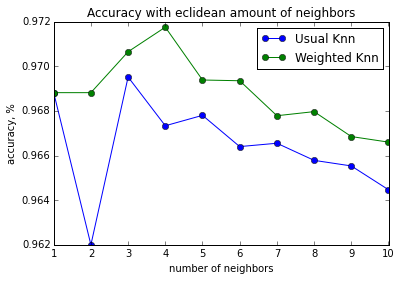

In [66]:
plt.plot(k, accuracy, '-o', k, accuracy_smooth_ecl, '-o')
plt.title('Accuracy with eclidean amount of neighbors')
plt.legend(['Usual Knn', 'Weighted Knn'], loc='upper right')
plt.ylabel('accuracy, %')
plt.xlabel('number of neighbors')

print('Время выполнения обычного алгоритма %.2f секунд (для одного фолда).' % timing)
print('Время выполнение взвешенного алгоритма %.2f секунд (для одного фолда).' % timing_smooth_ecl)
print('В среднем точность выше на %.4f .' % np.mean(accuracy_smooth_ecl - accuracy_ecl))

Как и ожидалось, скачок при $ k = 2 $ исчез. Наилучшая точность при $ k = 4 $ и равна 0.9719. Экспериментально получилось, что время работы взвешенного алгоритма меньше времени работы обычного, хотя должно было не значительно увеличиться (вероятная причина -- фоновые программы).

Косинусная метрика:

In [69]:
accuracy_smooth_cos = np.zeros((k.size))
timing_smooth_cos = 0
for train, test in kf:
    timing_smooth_cos -= time.time()
    accuracy_smooth_cos += k_neighbors_classifier_smooth(X_train[train], y_train[train],
                                       X_train[test], y_train[test], k = k, metric = 'cosine')
    timing_smooth_cos += time.time()
accuracy_smooth_cos /= folds
timing_smooth_cos /= folds

Время выполнения обычного алгоритма 164.85 секунд (для одного фолда).
Время выполнение взвешенного алгоритма 165.64 секунд (для одного фолда).
В среднем точность выше на 0.0015


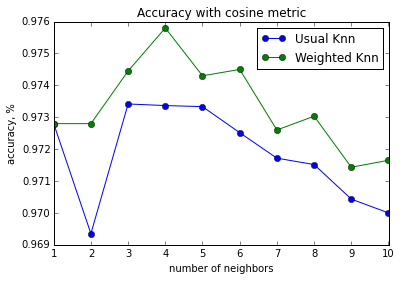

In [72]:
plt.plot(k, accuracy_cos, '-o', k, accuracy_smooth_cos, '-o')
plt.title('Accuracy with cosine metric')
plt.legend(['Usual Knn', 'Weighted Knn'], loc='upper right')
plt.ylabel('accuracy, %')
plt.xlabel('number of neighbors')

print('Время выполнения обычного алгоритма %.2f секунд (для одного фолда).' % timing_cos)
print('Время выполнение взвешенного алгоритма %.2f секунд (для одного фолда).' % timing_smooth_cos)
print('В среднем точность выше на %.4f' % np.mean(accuracy_smooth_cos - accuracy_cos))

Как видно, для косинусной метрики качество тоже незначительно улучшается. Наилучший результат при $ k = 4 $. 

#### 9. Применить лучший алгоритм к исходной обучающей и тестовой выборке. Подсчитать точность. Сравнить с точностью по кросс-валидации. Сравнить с указанной в Интернете точностью лучших алгоритмов на данной выборке.

In [121]:
final_accuracy, predict  = k_neighbors_classifier_smooth(X_train, y_train = y_train, X_test = X_test,
                                                         y_test = y_test,  k = k, metric = 'cosine', 
                                                         return_classes = True)


Наилучшая точность 0.9761 при k = 4.


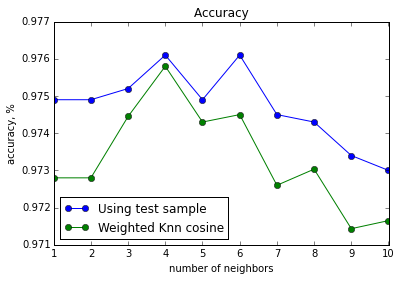

In [122]:
plt.plot(k, final_accuracy, '-o', k, accuracy_smooth_cos, '-o')
plt.title('Accuracy ')
plt.legend(['Using test sample', 'Weighted Knn cosine'], loc= 'lower left')
plt.ylabel('accuracy, %')
plt.xlabel('number of neighbors')
print("Наилучшая точность %.4f при k = %d." % (final_accuracy.max(), final_accuracy.argmax() + 1))

Улучшение качества на тестовой выборке связано с увеличением обучающей выборки. Однако, на данной выборке была получена точность 0.976 при использовании kNN-алгоритма и 0.9977 при использовании глубинных нейронных сетей (по данным [источника 1]('http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=E0F3BDC7642FBA1D8E2811526BD0E596?doi=10.1.1.106.3963&rep=rep1&type=pdf') и [источника 2]('http://repository.supsi.ch/5145/1/IDSIA-04-12.pdf')). Метод ближайших соседей показал один из лучших результатов на данной выборке. В [источнике 1]('http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=E0F3BDC7642FBA1D8E2811526BD0E596?doi=10.1.1.106.3963&rep=rep1&type=pdf') kNN считался на евклидовой метрике и при $ k = 3 $ . В пунктах 7-8 показано, что евклидова метрика ведет себя хуже чем косинусная на подобных выборках. Результаты точности же могут не значительно отличаться из-за произвольности разбиения выборки.  

#### 10. Визуализировать несколько объектов из тестовой выборки, на которых были допущены ошибки. Проанализировать и указать их общие черты. Построить и проанализировать матрицу ошибок (confusion matrix). Можно воспользоваться функцией sklearn.metrics.confusion_matrix.

In [130]:
predict = predict[:, final_accuracy.argmax()] # выберем лучший вариант

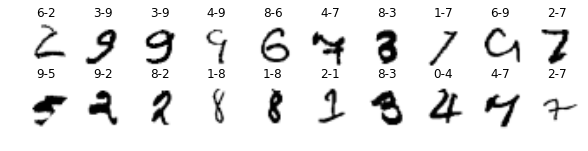

In [131]:
index = np.where(y_test != predict)[0]
index = index[0:20]
plt.figure(figsize = (10, 2))
for i in range(2):
    for j in range(10):
        image = X_test[index[i*10 + j]]
        image = image.reshape((28,28)) # делаем изображение квадратным 
        plt.subplot(2, 10, i*10 + j + 1) # указываем номер изображения
        plt.imshow(image, cmap = "Greys")
        plt.title('%d-%d' % (predict[index[i*10 + j]], y_test[index[i*10 + j]]))
        plt.axis("off")

*Надписи над изображениями указывают предсказанный класс и реальный класс соответственно.*

Почти все ошибочно классифицированные объекты можно поделить на 2 класса:

* Плохо написанные цифры(такие как (1,9), (1,10), (2,1))
* Жирные изображения. Из-за большого объема "тонкие" объекты из другого класса оказываются ближе других.


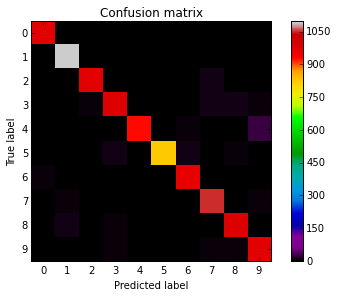

In [132]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predict)
plt.imshow(cm, interpolation='nearest', cmap= plt.cm.spectral)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Как оказалось, алгоритм больше всего ошибается в определении четвертки (считает девяткой). Алгоритм хорошо предсказывает единицу и ноль.

## Часть 2

#### 11. Загрузить обучающую выборку датасета 20 newsgroups при помощи метода sklearn.datasets.fetch_20newsgroups. Убрать все заголовки, подписи и цитаты, используя аргумент remove.

In [1]:
from  sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(subset='train', remove = ('headers', 'footers', 'quotes'))


#### 12. Перевести во всех документах все буквы в нижний регистр. Заменить во всех документах символы, не являющиеся буквами и цифрами, на пробелы. Полезные функции: str.lower, str.isalnum.

In [2]:
# не нашел другого способа, как явного укзаания заменяемых символов.
# не совсем понял как пользоваться isalnum в данной задачи, так как оставляем пробелы.
replace_chars = '@!"#$%&\'()*+,-./:;=>?@[\\]^_`{|}~\t\n\r\x0b\x0c'
for i in range(len(data.data)):
    mail = data.data[i]
    mail = mail.lower()
    for char in replace_chars:
        mail = mail.replace(char, ' ')
    data.data[i] = mail
 

#### 13. Разбить каждый документ на термы по пробельным символам (пробелы, переносы строки). Полезная функция: str.split.


In [3]:
data_formatted = []
for mail in data.data:
    data_formatted += [mail.split()]

#### 14. Преобразовать датасет в разреженную матрицу scipy.sparse.csr_matrix, где значение x в позиции (i, j) означает, что в документе i слово j встретилось x раз. Необходимо воспользоваться наиболее эффективным конструктором csr_matrix((data, indices, indptr), shape=(M, N)).

Так как потом придеться преобразовывать тестовую выборку напишем функцию:

In [4]:
import numpy as np

def make_scr_type(data, pull):
    """
    return indptr, indices, data of type np.array 
    with for use scipy.sparse.csr_matrix"""
    
    indptr = []
    cur_pos = 0
    indices = []
    data_docs = []
    pull_len = len(pull)
    for mail in data:
        indptr += [cur_pos] # начало документа 
        start = cur_pos # продублируем для удобства
        for word in mail:
            # ищем было ли такое слово раньше в общем пуле
            try:
                ind = pull.index(word)
            except ValueError:
                pull += [word]
                ind = pull_len
                pull_len += 1
            # ищем было ли такое слово раньше в документе
            try:
                ind2 = indices.index(ind, start)
            except ValueError:
                data_docs += [0]
                indices += [ind]
                ind2 = cur_pos
                cur_pos += 1
            data_docs[ind2] += 1
    indptr += [cur_pos]
    indprt_np = np.array(indptr)
    indices_np = np.array(indices)
    data_np = np.array(data_docs)
    return  data_np, indices_np, indprt_np

Созданим словарь всех используемых в документах слов и преобразуем обучающую выборку:

In [6]:
from scipy.sparse import csr_matrix

pull = [] # словарь
data_doc, indices, indptr = make_scr_type(data_formatted, pull)

sm_data = csr_matrix((data_doc, indices, indptr), shape = (len(data_formatted), int(len(pull) * 1.5)))

длина матрицы домножается на 1.5 на случай новых слов в тестовой выборке.

#### 15. Произвести tf-idf преобразование датасета при помощи sklearn.feature_extraction.text.TfidfTransformer. Используйте параметры по умолчанию.

In [7]:
from sklearn.feature_extraction.text import TfidfTransformer

TT = TfidfTransformer().fit(sm_data)
new_data = TT.transform(sm_data)

#### 16. Оценить точность (долю правильно предсказанных ответов) и скорость метода k ближайших соседей при помощи кросс-валидации с 3 фолдами. Требования к реализации – аналогично пункту 6. Исследуйте на одних и тех же фолдах влияние следующих факторов:

In [14]:
# подготовительные шаги
folds = 3
k = np.arange(1, 11, 1)
kf = My_kfold(sm_data.shape[0], n_folds = folds)
labels = data.target

**Пункт 1. k от 1 до 10 (только влияние на точность).**

In [182]:
accuracy_ecl = np.zeros((k.size))
timing_ecl = 0
for train, test in kf:
    timing_ecl -= time.time()
    accuracy_ecl += k_neighbors_classifier(sm_data[train], labels[train],
                                           sm_data[test], labels[test], k = k, classes = 20)
    timing_ecl += time.time()
accuracy_ecl /= folds
timing_ecl /= folds


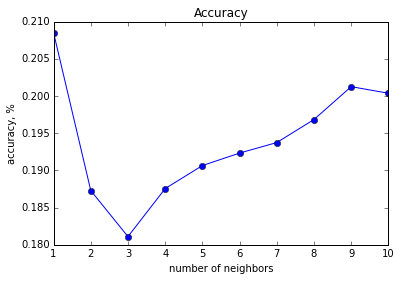

In [183]:
plt.plot(k, accuracy_ecl, '-o')
plt.title('Accuracy')
plt.ylabel('accuracy, %')
plt.xlabel('number of neighbors')

Как видно, метод ближайщий соседей плохо решает задачу с большой размерностью пространства и малым числом ненулевых параметров у объектов (в частности можно это объяснить "[проклятием размерности]('https://github.com/esokolov/ml-course-msu/blob/master/ML15/lecture-notes/Sem02_knn.pdf')" kNN). 

**Пункт 2. Используется евклидова или косинусная метрика.**

In [189]:
accuracy_cos = np.zeros((k.size))
timing_cos = 0

for train, test in kf:
    timing_cos -= time.time()
    accuracy_cos += k_neighbors_classifier(sm_data[train],labels[train], sm_data[test],
                                           labels[test], k = k, classes = 20, metric = 'cosine')
    timing_cos += time.time()

timing_cos /= folds
accuracy_cos /= folds

Bремя работы алгоритма на евклидовой метрике 3.54 секунд (для одного фолда)
Bремя работы алгоритма на косинусной метрике 2.27 секунд (для одного фолда)


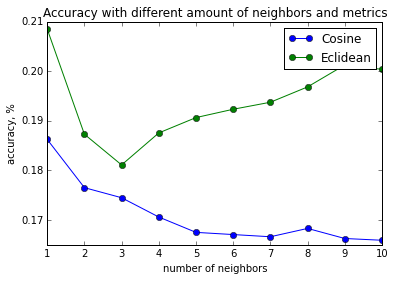

In [190]:
plt.plot(k, accuracy_cos,'-o', k, accuracy_ecl, '-o')
plt.title('Accuracy with different amount of neighbors and metrics')
plt.legend(['Cosine', 'Eclidean'], loc='upper right')
plt.ylabel('accuracy, %')
plt.xlabel('number of neighbors')

print("Bремя работы алгоритма на евклидовой метрике %.2f секунд (для одного фолда)" % timing_ecl)
print("Bремя работы алгоритма на косинусной метрике %.2f секунд (для одного фолда)" % timing_cos)

Косинусная метрика над обычной разряженной матрицой только ухудшает точность алгоритма.

**Пункт 3. Используется ли преобразование tf-idf:**

In [191]:
# сразу оба метода

accuracy_ecl_tf = np.zeros((k.size))
timing_ecl_tf = 0
for train, test in kf:
    timing_ecl_tf -= time.time()
    accuracy_ecl_tf += k_neighbors_classifier(new_data[train], labels[train],
                                           new_data[test], labels[test], k = k, classes = 20)
    timing_ecl_tf += time.time()
accuracy_ecl_tf /= folds
timing_ecl_tf /= folds

accuracy_cos_tf = np.zeros((k.size))
timing_cos_tf = 0

for train, test in kf:
    timing_cos_tf -= time.time()
    accuracy_cos_tf += k_neighbors_classifier(new_data[train],labels[train], new_data[test],
                                           labels[test], k = k, classes = 20, metric = 'cosine')
    timing_cos_tf += time.time()

timing_cos_tf /= folds
accuracy_cos_tf /= folds

Bремя работы алгоритма на евклидовой метрике 3.53 секунд (для одного фолда)
Bремя работы алгоритма на косинусной метрике 3.25 секунд (для одного фолда)


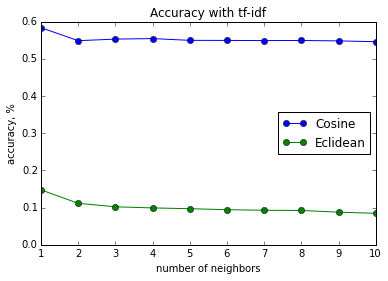

In [195]:
plt.plot(k, accuracy_cos_tf,'-o', k, accuracy_ecl_tf, '-o')
plt.title('Accuracy with tf-idf')
plt.legend(['Cosine', 'Eclidean'], loc='center right')
plt.ylabel('accuracy, %')
plt.xlabel('number of neighbors')

print("Bремя работы алгоритма на евклидовой метрике %.2f секунд (для одного фолда)" % timing_ecl_tf)
print("Bремя работы алгоритма на косинусной метрике %.2f секунд (для одного фолда)" % timing_cos_tf)

Tf-idf преобразование значительно улучшает точность алгоритма, так как маловажные слова или неверно употребленные играют меньшую роль. Косинусную меру часто используют для классификации текстов ([источник]('https://github.com/esokolov/ml-course-msu/blob/master/ML15/lecture-notes/Sem02_knn.pdf')), что нелья сказать об евклидовой и из графика видно почему. Точность алгоритмов можно было б повысить, удалив общие слова (используемые во многих документов разных классов). 

Воможная причина малой точности евклидой метрики, что тексты из одного класса очень разные и поэтому находятся далеко друг от друга. А тексты, которые состоят из одного слова (такие есть в выборке), оказываются ближе других. Вообще такие тексты стоило б исключить из выборки, так как они  только ухудшают точность алгоритма.

**Пункт 4.Используются взвешенный или невзвешенный метод k ближайших соседей. **

Понятно, что единственный классификатор, который более менее классифицирует это с преобразование tf-idf на косинусной метрике. На нем и посмотрим как влияет на точность взвешенность голоса:

In [30]:
accuracy_smooth_cos_tf = np.zeros((k.size))
timing_smooth_cos_tf = 0
for train, test in kf:
    timing_smooth_cos_tf -= time.time()
    accuracy_smooth_cos_tf += k_neighbors_classifier_smooth(new_data[train], labels[train],
                                       new_data[test], labels[test], classes = 20, k = k, metric = 'cosine')
    timing_smooth_cos_tf += time.time()
accuracy_smooth_cos_tf /= folds
timing_smooth_cos_tf /= folds

Время выполнения обычного алгоритма 3.25 секунд (для одного фолда).
Время выполнение взвешенного алгоритма 3.12 секунд (для одного фолда).
В среднем точность выше на 0.0218


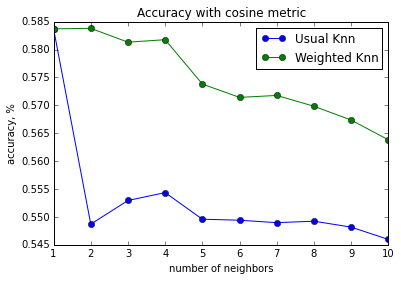

In [201]:
plt.plot(k, accuracy_cos_tf, '-o', k, accuracy_smooth_cos_tf, '-o')
plt.title('Accuracy with cosine metric')
plt.legend(['Usual Knn', 'Weighted Knn'], loc='upper right')
plt.ylabel('accuracy, %')
plt.xlabel('number of neighbors')

print('Время выполнения обычного алгоритма %.2f секунд (для одного фолда).' % timing_cos_tf)
print('Время выполнение взвешенного алгоритма %.2f секунд (для одного фолда).' % timing_smooth_cos_tf)
print('В среднем точность выше на %.4f' % np.mean(accuracy_smooth_cos_tf - accuracy_cos_tf))

Взвешенный алгоритм как и в первой части незначительно повышает точность в среднем, но наилучшее значение не может улучшить, так оно при $ k = 1 $. 

#### 17. Загрузите тестовую выборку (параметр subset метода fetch_20newsgroups). Примените лучший алгоритм к тестовой выборке. Сравнить точность с полученной по кросс-валидации.

Загрузим тестовую выборку и сделаем все необходимые преобразования, чтобы привести к tf-idf формату тестовую выборку:

In [8]:
# загрузка
test = fetch_20newsgroups(subset='test', remove = ('headers', 'footers', 'quotes'))
X_test0 = test.data
y_test = test.target

# очищение текста
replace_chars = '@!"#$%&\'()*+,-./:;=>?@[\\]^_`{|}~\t\n\r\x0b\x0c'
for i in range(len(X_test0)):
    mail = X_test[i]
    mail = mail.lower()
    for char in replace_chars:
        mail = mail.replace(char, ' ')
    X_test[i] = mail
    
# разбиваем на термы
for i in range(len(X_test)):
    X_test[i] = X_test[i].split()

# преобразуем в разряженную матрицу
len_pull = len(pull)
data_test, indices_test, indptr_test = make_scr_type(X_test, pull)
sm_data_test = csr_matrix((data_test, indices_test, indptr_test), shape = (len(X_test), int(len_pull * 1.5)))
X_test_td = TT.transform(sm_data_test)

Применим к полученной тестовой выборке взвешенный метод с косинусной метрикой (наилучший вариант):

In [17]:
accuracy_final, predict = k_neighbors_classifier_smooth(new_data, y_train = labels, return_classes = True,
                                                        X_test = X_test_td, y_test =  y_test, classes = 20, k = k,
                                                        metric = 'cosine')

Наилучшая точность 0.5167 при k = 5.


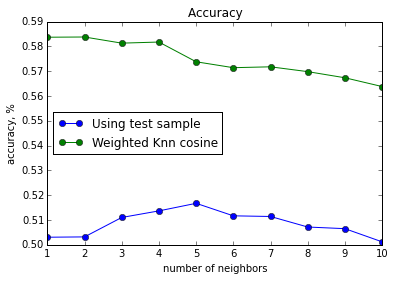

In [31]:
plt.plot(k, accuracy_final, '-o', k, accuracy_smooth_cos_tf, '-o')
plt.title('Accuracy ')
plt.legend(['Using test sample', 'Weighted Knn cosine'], loc= 'center left')
plt.ylabel('accuracy, %')
plt.xlabel('number of neighbors')
print("Наилучшая точность %.4f при k = %d." % (accuracy_final.max(), accuracy_final.argmax() + 1))

In [32]:
pr =  (len(pull) - len_pull) / len_pull *100
print("размер словаря после добавления тестовой выборки увеличился на %.2f %s." % (pr, '%')) 

размер словаря после добавления тестовой выборки увеличился на 31.87 %.


Несмотря на увеличение обучаемой выборки, точность на тестовой выборки значительно упала. Одна из причин понижения это большой набор новых слов, которых до этого не было и алгоритм не учитывает их существование (словарь увеличился почти на треть). Причем, скорее всего добавились не общие слова, а именно профильные. То есть алгоритму приходлиось классифицировать по общим словам, которые одинаково относяться ко всем темам. 

#### 18. Вывести несколько документов из тестовой выборки, на которых были допущены ошибки. Проанализировать их. Построить и проанализировать матрицу ошибок (confusion matrix). Можно воспользоваться функцией sklearn.metrics.confusion_matrix.

In [82]:
predict = predict[:, 4] # выберем наилучшую точность при k = 5
index = np.where(predict != y_test)[0]
index = index[:10]
names = data.target_names
j = 0
for i in index:
    j += 1
    print('Текст принадлежит %s классу, а был определен в %s.\n' % (names[y_test[i]], names[predict[i]]))
    print('Текст', j,':', X_test0[i], '\n\n')

Текст принадлежит rec.autos классу, а был определен в talk.politics.misc.

Текст 1 : I am a little confused on all of the models of the 88-89 bonnevilles.
I have heard of the LE SE LSE SSE SSEI. Could someone tell me the
differences are far as features or performance. I am also curious to
know what the book value is for prefereably the 89 model. And how much
less than book value can you usually get them for. In other words how
much are they in demand this time of year. I have heard that the mid-spring
early summer is the best time to buy. 


Текст принадлежит alt.atheism классу, а был определен в talk.politics.mideast.

Текст 2 : 
In a word, yes.
 


Текст принадлежит talk.religion.misc классу, а был определен в alt.atheism.

Текст 3 : 
I've just spent two solid months arguing that no such thing as an
objective moral system exists. 


Текст принадлежит soc.religion.christian классу, а был определен в talk.politics.guns.

Текст 4 : Dishonest money dwindles away, but he who gathers money

Анализируя тексты можно выделить несколько причин неправильной классификации:

1. В некоторых текстах слишком мало информации, чтобы их классифицировать.
2. Иногда в тексте можно выделить несколько тем и алгоритм выбирает не основную.
3. В некоторых текстах вообще сложно понять, что за тема (как, например, второй текст).

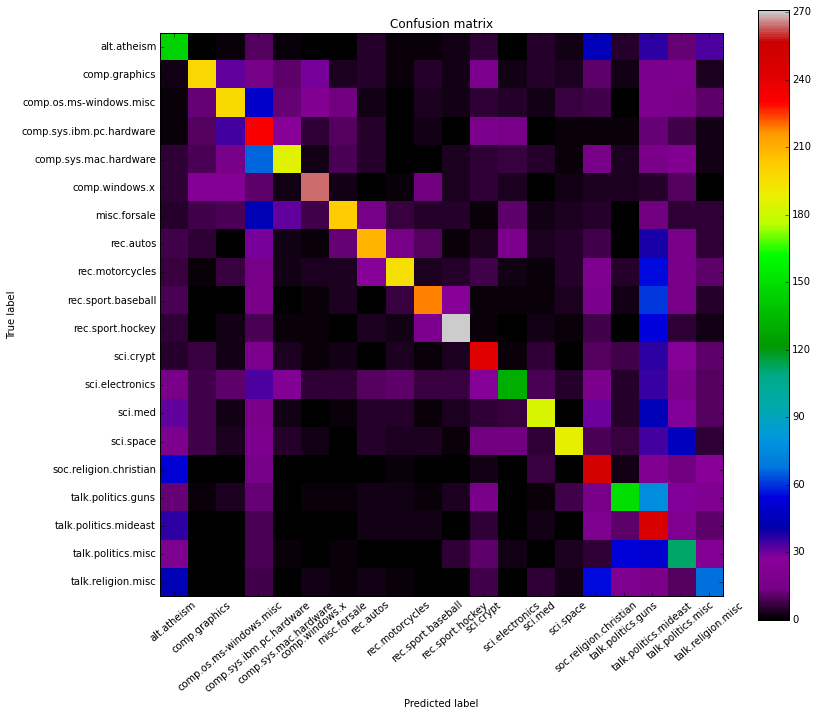

In [93]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predict)
plt.figure(figsize = (12,10))
plt.imshow(cm, interpolation='nearest', cmap= plt.cm.spectral)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(data.target_names))
plt.xticks(tick_marks, data.target_names, rotation=40)
plt.yticks(tick_marks, data.target_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Очень много документов было ошибочно классифицировано в класс обсуждение-политика-ближний-восток. Так же часто путалась религия и атеизм (впрочем на мой взгляд, это в одну тему можно объединить). Не мало вариантов, где общая тема была верно определена, а подтема - нет.

#### 19. Сделать выводы: в каких случаях следует пользоваться каким алгоритмом, какие параметры важно оптимизировать, какие ошибки допускают алгоритмы.

Данные эксперименты подтверждают теоретические выводы о применимости метода ближайших соседей:

1. kNN плохо работает при очень больших размерностях пространства и разряженных матрицах, то есть в таких задачах, как классификация документов по темам. Если и применять данный алгоритм, то только при использовании косинусной метрики.
2. Метод ближайших соседей дает хороший результат на небольших размерностях пространства. Здесь также лучше применять косинусную метрику. 

Так же было подтверждено:

1. Взвешенный метод при незначительном увеличении времени улучшает точность алгоритма
2. Алгоритм долго работает

В обоих экспериментах было получено, что наилучшая точность достигается при k (количество соседей) лежащем в интервале [3, 5]. В процессе выполнения задания, не было замечено никаких свойственных для kNN ошибок, которые не зависят от выборки объектов.